# Simulation of ridge regression under augmentation

This notebook simulates ridge regression estimator and empircal average. Throughout all settings the true value of $B$ is the identity matrix.

## Utility functions

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import time
import os
import _pickle as pk
import scipy.stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import colors

# Data processing 
def dataset_map(fn, data, fn_arg):   # takes in data of shape [i, ...] where i=1,...,n, and apply fn to each i^th data pooint with fn_arg
    return [fn(x, fn_arg) for x in data]
    
def expand(t, k): # takes in object of shape (2, d) and repeats it k times to give (k, 2, d) object
    return np.repeat([t], [k], axis=0)

# Augmentation candidates
def generate_random_crops(k, p):
    bernoullis = np.random.binomial(1, p, [k])
    top = np.array([[1.,0.],[0.,0.]])
    btm = np.array([[0.,0.],[0.,1.]])
    transforms = [ top if b==1 else btm for b in bernoullis]
    return np.array(transforms)

def iid_random_crop(t, params): # takes in object of shape (k, 2, d) and outputs object of shape (k,2,d)
    crop_gen, crop_gen_params, dummy = params
    k = t.shape[0]
    crops = crop_gen(k, crop_gen_params) # generates array of crops of shape (k, d, d)
    cropped_x = np.einsum('lpq, lq -> lp', crops, t[:, 0] )  # t[:,0] is the shape (k, d) object representing x
    cropped_y = np.einsum('lpq, lq -> lp', crops, t[:, 1] ) # t[:,1] is the shape (k, d) object representing y
    aug_t = np.array([cropped_x, cropped_y]) # object of shape (2, k, d)
    return np.transpose(aug_t, [1,0,2]) # swap axes to obtain shape (k, 2, d)

def rep_random_crop(t, params):
    rep_crops, dummy = params
    cropped_x = np.einsum('lpq, lq -> lp', rep_crops, t[:, 0] )
    cropped_y = np.einsum('lpq, lq -> lp', rep_crops, t[:, 1] )
    aug_t = np.array([cropped_x, cropped_y])
    return np.transpose(aug_t, [1,0,2])

# other operations
def add_gaussian_noise(x, c):  # takes in x, returns (x, y) where y = x + gaussian noise of scale c
    return np.array([x, np.random.normal(0.0, c, list(x.shape)) + x])  

def sum_xx_xy(t, dummy): 
    xx = np.einsum('lp,lq -> pq', t[:,0], t[:,0])
    xy = np.einsum('lp,lq -> pq', t[:,0], t[:,1])
    return np.array([xx, xy])

def generate_dataset(mu, cov_L, n, noise_fn, noise_params): # outputs dataset of shape (n, 2, d) representing n pairs of (x, y)
    samples = np.einsum('iq, qp -> ip', np.random.normal(0.0, 1.0, [n] + list(mu.shape)), cov_L)
    samples = [x + mu for x in samples]
    return dataset_map(noise_fn, samples, noise_params)

def compute_ridge_B(expanded_dataset, n, k, d, lamb):
    xx_xy = np.sum(dataset_map(sum_xx_xy, expanded_dataset, None), axis=0)
    return np.matmul(np.linalg.inv(xx_xy[0] + n*k*lamb*np.eye(d)), xx_xy[1]) # n * k * lambda

def compute_ridge_risk(B, mu, cov, c):
    # risk in our model is calculated as E[ || Y - B X ||^2 ] = E || X + noise - BX ||^2 ] = E[ ||(B-I)X||^2 - 2 noise^\top (B-I)X + ||noise||^2 ] = E[ ||(B-I)X||^2] + d c^2
    # the final equality is because noise is N(0, c^2 I_d) and therefore E[ ||noise||^2] = c^2 d
    # moreover E[ ||(B-I)X||^2] = E[ Tr( (B-I)X X^\top (B-I)^\top  ) ] = Tr((B-I)^top (B-I) E[XX^\top] ) 
    d = B.shape[0]
    B_I = B - np.eye(d)
    second_moment = cov + np.einsum('i,j->ij',mu,mu)
    risk = np.einsum('ii', np.matmul(np.matmul(B_I, B_I.T), second_moment) ) + d * c**2
    return risk

In [2]:
def main(total_sim, mu, cov_L, cov, n, noise_fn, noise_params, k, iid_aug_fn, iid_aug_params, aug_gen, aug_gen_params, rep_aug_fn, rep_aug_params, d, lamb):
    start = time.time()
    no_aug_B_list = []; iid_aug_B_list = []; rep_aug_B_list = []
    no_aug_pred_risk_list = []; iid_aug_pred_risk_list = []; rep_aug_pred_risk_list = []
    no_aug_mean_list = []; iid_aug_mean_list = []; rep_aug_mean_list = []
    for i in range(total_sim):
        dataset = generate_dataset(mu, cov_L, n, noise_fn, noise_params) # object of shape (n, 2, d)
        no_aug_dataset = dataset_map(expand, dataset, k) # object of shape (n, k, 2, d)
        iid_aug_dataset = dataset_map(iid_aug_fn, no_aug_dataset, 
                                      (aug_gen, aug_gen_params, iid_aug_params))
        rep_augs = aug_gen(k, aug_gen_params)
        rep_aug_dataset = dataset_map(rep_aug_fn, no_aug_dataset, 
                                      (rep_augs, rep_aug_params))
        
        # compute statistics
        no_aug_B = compute_ridge_B(no_aug_dataset, n, k, d, lamb) 
        iid_aug_B = compute_ridge_B(iid_aug_dataset, n, k, d, lamb)
        rep_aug_B =  compute_ridge_B(rep_aug_dataset, n, k, d, lamb) 
        no_aug_B_list.append( no_aug_B )
        iid_aug_B_list.append( iid_aug_B  )
        rep_aug_B_list.append( rep_aug_B )
        
        no_aug_pred_risk_list.append( compute_ridge_risk(no_aug_B, mu, cov, noise_params) )
        iid_aug_pred_risk_list.append( compute_ridge_risk(iid_aug_B, mu, cov, noise_params) )
        rep_aug_pred_risk_list.append( compute_ridge_risk(rep_aug_B, mu, cov, noise_params) )
        
        no_aug_mean_list.append( np.mean([x_i for x_i in no_aug_dataset], axis=(0,1)) )
        iid_aug_mean_list.append( np.mean([x_i for x_i in iid_aug_dataset], axis=(0,1)) )
        rep_aug_mean_list.append(  np.mean([x_i for x_i in rep_aug_dataset], axis=(0,1)) )
        
    
    return no_aug_B_list, iid_aug_B_list, rep_aug_B_list, no_aug_pred_risk_list, iid_aug_pred_risk_list, rep_aug_pred_risk_list, no_aug_mean_list, iid_aug_mean_list, rep_aug_mean_list 

## Simulation - cropping

In [3]:
seed = 0
np.random.seed(seed)

k=50
d=2
n=200
b=d

mu_scale = 0
mu = mu_scale * np.ones(d)
rho = 0.5
cov = np.diag([rho]*(d-1), -1) + np.diag([1.]*d, 0) + np.diag([rho]*(d-1), 1)
cov_L = np.linalg.cholesky(cov)

noise_fn = add_gaussian_noise
c = 0.1
noise_params = c

iid_aug_fn = iid_random_crop
iid_aug_params = None

aug_gen = generate_random_crops
aug_gen_params = 1/2 #p

rep_aug_fn = rep_random_crop
rep_aug_params = None

lamb = 0.1

total_sim = 1000

no_aug_B_list, iid_aug_B_list, rep_aug_B_list, no_aug_pred_risk_list, iid_aug_pred_risk_list, rep_aug_pred_risk_list, no_aug_mean_list, iid_aug_mean_list, rep_aug_mean_list = main(
                total_sim, mu, cov_L, cov, n, noise_fn, noise_params, k, iid_aug_fn, iid_aug_params, aug_gen, aug_gen_params, rep_aug_fn, rep_aug_params, d, lamb)

## Plot - utility functions

In [4]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


plt.rcParams.update({ 
    "text.usetex": True,
    "font.weight": "heavy",
    "font.size": 14,
    "text.latex.preamble": r"\usepackage{amsmath}"
})

## Plot - Figure 1 for random cropping

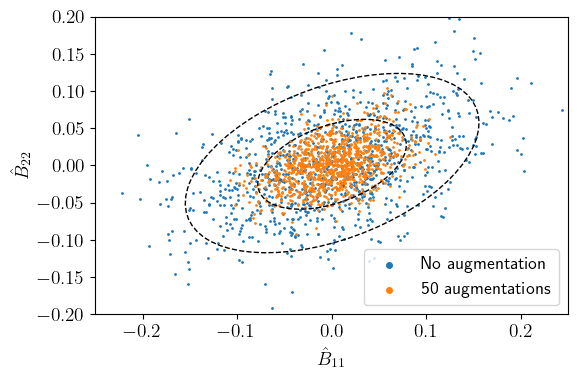

In [5]:
no_aug_mean00 = [x[0,0] for x in no_aug_mean_list]
no_aug_mean11 = [x[1,1] for x in no_aug_mean_list]
iid_aug_mean00 = [x[0,0] for x in iid_aug_mean_list]
iid_aug_mean11 = [x[1,1] for x in iid_aug_mean_list]

fig = plt.figure(figsize=(6, 4), dpi=100)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(no_aug_mean00, no_aug_mean11, s=1, label='No augmentation')
ax.scatter(iid_aug_mean00, iid_aug_mean11, s=1, label='50 augmentations')
ax.legend(loc='lower right', markerscale=4, prop={'size':13})

plt.xlabel(r'$\hat{B}_{11}$')
plt.ylabel(r'$\hat{B}_{22}$')

confidence_ellipse(no_aug_mean00, no_aug_mean11, ax, facecolor='none', n_std=2.0, ls='dashed', lw=1, edgecolor='black')
confidence_ellipse(iid_aug_mean00, iid_aug_mean11, ax, facecolor='none', n_std=2.0, ls='dashed', lw=1, edgecolor='black')

plt.xlim([-0.25, 0.25])
plt.ylim([-0.20, 0.20])
plt.locator_params(axis='y', nbins=10)
plt.tight_layout()
plt.savefig('fig1_average_crop.pdf', dpi=fig.dpi, bbox_inches='tight')
plt.show()

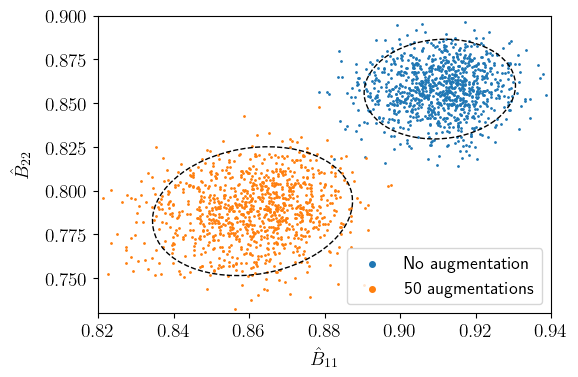

In [6]:
no_aug_B00 = [x[0,0] for x in no_aug_B_list]
no_aug_B11 = [x[1,1] for x in no_aug_B_list]
iid_aug_B00 = [x[0,0] for x in iid_aug_B_list]
iid_aug_B11 = [x[1,1] for x in iid_aug_B_list]

fig = plt.figure(figsize=(6, 4), dpi=100)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(no_aug_B00, no_aug_B11, s=1, label='No augmentation')
ax.scatter(iid_aug_B00, iid_aug_B11, s=1, label='50 augmentations')
ax.legend(loc='lower right', markerscale=4, prop={'size':13})

plt.xlabel(r'$\hat{B}_{11}$')
plt.ylabel(r'$\hat{B}_{22}$', labelpad=10)

confidence_ellipse(no_aug_B00, no_aug_B11, ax, facecolor='none', n_std=2.0, ls='dashed', lw=1, edgecolor='black')
confidence_ellipse(iid_aug_B00, iid_aug_B11, ax, facecolor='none', n_std=2.0, ls='dashed', lw=1, edgecolor='black')

plt.xlim([0.82, 0.94])
plt.ylim([0.73, 0.90])
plt.tight_layout()
plt.savefig('fig1_ridge_crop.pdf', dpi=fig.dpi, bbox_inches='tight')
plt.show()